---
- Leaf Classification (Smooth vs Serrated) using PyTorch + ConvNeXt
- Author: Messaoudi-Belkacem
- Date: 2025-11-11
---

# 1. IMPORTS

In [1]:
import os, random, math, time
from dataclasses import dataclass
from typing import Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.cuda.amp import autocast, GradScaler
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights


import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    balanced_accuracy_score, cohen_kappa_score,
    log_loss, roc_auc_score, classification_report,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)

# Set random seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else 
                      ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

🖥️  Using device: cuda
🎮 GPU: Tesla P100-PCIE-16GB
💾 GPU Memory: 17.06 GB


# 2. DATA CONFIGURATION

In [2]:
DATA_DIR = "/kaggle/input/plant-leaves-dataset/feuilles_plantes"

weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
default_transforms = weights.transforms()

# Training transformations
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(30),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=default_transforms.mean, std=default_transforms.std),
    transforms.RandomErasing(p=0.2)
])

# Validation/Test transformations (no augmentation)
transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=default_transforms.mean,
        std=default_transforms.std
    )
])

# Load full dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
num_classes = len(full_dataset.classes)

print(f"\n📁 Dataset Info:")
print(f"   Classes: {full_dataset.classes}")
print(f"   Total images: {len(full_dataset)}")
print(f"   Number of classes: {num_classes}")


📁 Dataset Info:
   Classes: ['dente', 'lisse']
   Total images: 6529
   Number of classes: 2


# 3. STRATIFIED TRAIN/VAL/TEST SPLIT

In [3]:
@dataclass
class Splits:
    train: Subset
    val: Subset
    test: Subset

def stratified_split(dataset: datasets.ImageFolder,
                     train_ratio: float = 0.7,
                     val_ratio: float = 0.15,
                     test_ratio: float = 0.15,
                     seed: int = 0) -> Splits:
    """Returns train/val/test Subsets with stratified class distribution."""
    rng = np.random.RandomState(seed)
    
    # Group indices by class label
    class_indices = {}
    for idx, (_, label) in enumerate(dataset.imgs):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    # Split each class proportionally
    for label, indices in class_indices.items():
        indices = np.array(indices)
        rng.shuffle(indices)
        
        n_total = len(indices)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        
        train_indices.extend(indices[:n_train].tolist())
        val_indices.extend(indices[n_train:n_train+n_val].tolist())
        test_indices.extend(indices[n_train+n_val:].tolist())
    
    return Splits(
        train=Subset(dataset, train_indices),
        val=Subset(dataset, val_indices),
        test=Subset(dataset, test_indices)
    )

# Create splits
splits = stratified_split(full_dataset, 0.7, 0.15, 0.15, seed=0)

# Create optimized DataLoaders
train_loader = DataLoader(
    splits.train, 
    batch_size=64,
    shuffle=True, 
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

full_dataset.transform = transform_eval
val_loader = DataLoader(
    splits.val, 
    batch_size=256,  # Increased from 64
    shuffle=False, 
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    splits.test, 
    batch_size=256,
    shuffle=False, 
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

print(f"\n📊 Split sizes:")
print(f"   Train: {len(splits.train)}")
print(f"   Val: {len(splits.val)}")
print(f"   Test: {len(splits.test)}")


📊 Split sizes:
   Train: 4569
   Val: 979
   Test: 981


# 4. MODEL ARCHITECTURE (ConvNeXt)

In [4]:
def create_convnext_model(num_classes=2, model_size='tiny', freeze_backbone=True):
    """Create ConvNeXt model with pretrained weights."""
    print(f"\n🏗️  Building ConvNeXt-{model_size} model...")
    
    if model_size == 'tiny':
        model = models.convnext_tiny(weights='IMAGENET1K_V1')
    elif model_size == 'small':
        model = models.convnext_small(weights='IMAGENET1K_V1')
    elif model_size == 'base':
        model = models.convnext_base(weights='IMAGENET1K_V1')
    else:
        model = models.convnext_large(weights='IMAGENET1K_V1')
    
    # Freeze backbone if requested
    if freeze_backbone:
        print("   🔒 Freezing backbone layers...")
        for param in model.features.parameters():
            param.requires_grad = False
    
    # Replace classifier head
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, num_classes)
    
    return model

model = create_convnext_model(num_classes=num_classes, model_size='tiny', freeze_backbone=True)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")


🏗️  Building ConvNeXt-tiny model...


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:01<00:00, 75.1MB/s] 


   🔒 Freezing backbone layers...
   Total parameters: 27,821,666
   Trainable parameters: 3,074


# 5. TRAINING SETUP

In [5]:
# Only classifier head is trainable initially
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,  # Higher LR for new classifier head
    weight_decay=0.01
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)
scaler = GradScaler()

# Store initial criterion
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_89/1349073290.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


# 6. TRAINING & EVALUATION FUNCTIONS

In [6]:
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    """Train for one epoch with mixed precision."""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        total_loss += loss.item() * imgs.size(0)
        
        pbar.set_postfix({
            'loss': f'{loss.item():.3f}',
            'acc': f'{100.*correct/total:.1f}%'
        })
    
    return total_loss / len(loader.dataset), 100. * correct / total

@torch.no_grad()
def evaluate(model, loader, criterion):
    """Evaluate model without gradient computation."""
    model.eval()
    total_loss = 0.0
    y_true, y_pred, y_proba = [], [], []
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Validation', bar_format='{l_bar}{bar:30}{r_bar}', leave=False)
    
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_proba.extend(probs[:, 1].cpu().numpy())
        
        total_loss += loss.item() * imgs.size(0)
        
        pbar.set_postfix({
            'loss': f'{loss.item():.3f}',
            'acc': f'{100.*correct/total:.1f}%'
        })
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = 100. * correct / total
    return avg_loss, np.array(y_true), np.array(y_pred), np.array(y_proba), accuracy

def unfreeze_model(model, optimizer, unfreeze_from_stage=6, backbone_lr=1e-5, head_lr=1e-4):
    """
    Unfreeze backbone layers and create new optimizer with differential learning rates.
    
    ConvNeXt has 8 stages (features[0] to features[7]).
    - Stage 0: Stem
    - Stages 1-7: ConvNeXt blocks
    """
    print(f"\n🔓 Unfreezing backbone from stage {unfreeze_from_stage}...")
    
    # Unfreeze specified stages
    for i in range(unfreeze_from_stage, 8):
        for param in model.features[i].parameters():
            param.requires_grad = True
    
    # Create optimizer with differential learning rates
    optimizer = torch.optim.AdamW([
        {'params': model.features.parameters(), 'lr': backbone_lr},
        {'params': model.classifier.parameters(), 'lr': head_lr}
    ], weight_decay=0.01)
    
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Backbone LR: {backbone_lr:.2e}")
    print(f"   Head LR: {head_lr:.2e}")
    
    return optimizer

# 7. TRAINING LOOP

In [7]:
print("\n🚀 Starting training with Progressive Unfreezing...\n")

# Phase 1: Train only classifier head (frozen backbone)
PHASE1_EPOCHS = 8  # Train head only
PHASE2_EPOCHS = 16  # Fine-tune with unfrozen backbone
TOTAL_EPOCHS = PHASE1_EPOCHS + PHASE2_EPOCHS

best_val_acc = 0.0

print("=" * 60)
print("📍 PHASE 1: Training Classifier Head (Backbone Frozen)")
print("=" * 60 + "\n")

for epoch in range(PHASE1_EPOCHS):
    # Training
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    
    # Validation
    va_loss, y_t, y_p, y_s, va_acc = evaluate(model, val_loader, criterion)
    
    # Update learning rate
    scheduler.step(va_loss)
    
    # Print epoch summary
    print(f"📈 Epoch {epoch+1:02d}/{PHASE1_EPOCHS} | "
          f"Train: {tr_loss:.4f} ({tr_acc:.2f}%) | "
          f"Val: {va_loss:.4f} ({va_acc:.2f}%) | "
          f"LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save best model
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"   ✅ New best model saved! (Val Acc: {best_val_acc:.2f}%)")
    
    print()

print("\n" + "=" * 60)
print("📍 PHASE 2: Fine-tuning with Unfrozen Backbone")
print("=" * 60 + "\n")

# Unfreeze backbone and create new optimizer
optimizer = unfreeze_model(
    model, 
    optimizer, 
    unfreeze_from_stage=6,  # Unfreeze last 2 stages (6 and 7)
    backbone_lr=1e-5,       # Lower LR for pretrained weights
    head_lr=1e-4            # Higher LR for classifier
)

# Reset scheduler with new optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

for epoch in range(PHASE2_EPOCHS):
    # Training
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    
    # Validation
    va_loss, y_t, y_p, y_s, va_acc = evaluate(model, val_loader, criterion)
    
    # Update learning rate
    scheduler.step(va_loss)
    
    # Print epoch summary with both LRs
    print(f"📈 Epoch {PHASE1_EPOCHS + epoch+1:02d}/{TOTAL_EPOCHS} | "
          f"Train: {tr_loss:.4f} ({tr_acc:.2f}%) | "
          f"Val: {va_loss:.4f} ({va_acc:.2f}%) | "
          f"Backbone LR: {optimizer.param_groups[0]['lr']:.2e} | "
          f"Head LR: {optimizer.param_groups[1]['lr']:.2e}")
    
    # Save best model
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"   ✅ New best model saved! (Val Acc: {best_val_acc:.2f}%)")
    
    print()

print(f"\n✨ Training complete! Best Val Accuracy: {best_val_acc:.2f}%")


🚀 Starting training with Progressive Unfreezing...

📍 PHASE 1: Training Classifier Head (Backbone Frozen)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

/tmp/ipykernel_89/943453358.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 01/8 | Train: 0.2690 (90.41%) | Val: 0.1989 (93.05%) | LR: 1.00e-03
   ✅ New best model saved! (Val Acc: 93.05%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 02/8 | Train: 0.1696 (93.89%) | Val: 0.1728 (94.48%) | LR: 1.00e-03
   ✅ New best model saved! (Val Acc: 94.48%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 03/8 | Train: 0.1458 (94.79%) | Val: 0.1551 (94.89%) | LR: 1.00e-03
   ✅ New best model saved! (Val Acc: 94.89%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 04/8 | Train: 0.1308 (95.38%) | Val: 0.1464 (95.71%) | LR: 1.00e-03
   ✅ New best model saved! (Val Acc: 95.71%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 05/8 | Train: 0.1218 (95.89%) | Val: 0.1441 (95.40%) | LR: 1.00e-03



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 06/8 | Train: 0.1154 (95.95%) | Val: 0.1378 (95.81%) | LR: 1.00e-03
   ✅ New best model saved! (Val Acc: 95.81%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 07/8 | Train: 0.1059 (96.39%) | Val: 0.1381 (95.40%) | LR: 1.00e-03



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 08/8 | Train: 0.1056 (96.06%) | Val: 0.1351 (95.71%) | LR: 1.00e-03


📍 PHASE 2: Fine-tuning with Unfrozen Backbone


🔓 Unfreezing backbone from stage 6...
   Trainable parameters: 15,473,666
   Backbone LR: 1.00e-05
   Head LR: 1.00e-04


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 09/24 | Train: 0.0969 (96.67%) | Val: 0.1265 (95.81%) | Backbone LR: 1.00e-05 | Head LR: 1.00e-04



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 10/24 | Train: 0.0843 (97.00%) | Val: 0.1220 (95.91%) | Backbone LR: 1.00e-05 | Head LR: 1.00e-04
   ✅ New best model saved! (Val Acc: 95.91%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 11/24 | Train: 0.0676 (97.96%) | Val: 0.1170 (96.12%) | Backbone LR: 1.00e-05 | Head LR: 1.00e-04
   ✅ New best model saved! (Val Acc: 96.12%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 12/24 | Train: 0.0570 (98.23%) | Val: 0.1139 (96.22%) | Backbone LR: 1.00e-05 | Head LR: 1.00e-04
   ✅ New best model saved! (Val Acc: 96.22%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 13/24 | Train: 0.0482 (98.69%) | Val: 0.1125 (96.02%) | Backbone LR: 1.00e-05 | Head LR: 1.00e-04



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 14/24 | Train: 0.0425 (98.93%) | Val: 0.1078 (96.53%) | Backbone LR: 1.00e-05 | Head LR: 1.00e-04
   ✅ New best model saved! (Val Acc: 96.53%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 15/24 | Train: 0.0376 (99.06%) | Val: 0.1090 (96.22%) | Backbone LR: 1.00e-05 | Head LR: 1.00e-04



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 16/24 | Train: 0.0317 (99.26%) | Val: 0.1031 (96.53%) | Backbone LR: 1.00e-05 | Head LR: 1.00e-04



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 17/24 | Train: 0.0287 (99.23%) | Val: 0.1053 (96.53%) | Backbone LR: 1.00e-05 | Head LR: 1.00e-04



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 18/24 | Train: 0.0239 (99.30%) | Val: 0.1030 (96.53%) | Backbone LR: 1.00e-05 | Head LR: 1.00e-04



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 19/24 | Train: 0.0219 (99.63%) | Val: 0.1023 (96.53%) | Backbone LR: 1.00e-05 | Head LR: 1.00e-04



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 20/24 | Train: 0.0172 (99.56%) | Val: 0.1046 (96.63%) | Backbone LR: 1.00e-05 | Head LR: 1.00e-04
   ✅ New best model saved! (Val Acc: 96.63%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 21/24 | Train: 0.0151 (99.63%) | Val: 0.1040 (96.63%) | Backbone LR: 1.00e-05 | Head LR: 1.00e-04



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 22/24 | Train: 0.0166 (99.61%) | Val: 0.1010 (96.53%) | Backbone LR: 1.00e-05 | Head LR: 1.00e-04



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 23/24 | Train: 0.0149 (99.58%) | Val: 0.1064 (96.73%) | Backbone LR: 1.00e-05 | Head LR: 1.00e-04
   ✅ New best model saved! (Val Acc: 96.73%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 24/24 | Train: 0.0145 (99.72%) | Val: 0.0994 (96.42%) | Backbone LR: 1.00e-05 | Head LR: 1.00e-04


✨ Training complete! Best Val Accuracy: 96.73%


# 8. FINAL EVALUATION ON TEST SET

In [8]:
print("\n🧪 Evaluating on test set...")

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

te_loss, y_true, y_pred, y_proba, te_acc = evaluate(model, test_loader, criterion)

# Identify positive class
classes = full_dataset.classes
pos_class_name = classes[0]
pos_idx = classes.index(pos_class_name)

# Compute comprehensive metrics
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="binary", pos_label=pos_idx
)
bacc = balanced_accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
ll = log_loss(y_true, np.column_stack([1-y_proba, y_proba]))
auc = roc_auc_score((y_true==pos_idx).astype(int), y_proba)

# Print results
print("\n" + "="*60)
print("🎯 TEST SET PERFORMANCE")
print("="*60)
print(f"Test Loss         : {te_loss:.4f}")
print(f"Accuracy          : {acc:.4f} ({acc*100:.2f}%)")
print(f"Precision         : {prec:.4f}")
print(f"Recall            : {rec:.4f}")
print(f"F1 Score          : {f1:.4f}")
print(f"Balanced Accuracy : {bacc:.4f}")
print(f"Cohen's Kappa     : {kappa:.4f}")
print(f"Log Loss          : {ll:.4f}")
print(f"AUC-ROC           : {auc:.4f}")
print("\n" + "="*60)
print("📋 CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=classes))


🧪 Evaluating on test set...


Validation:   0%|                              | 0/4 [00:00<?, ?it/s]


🎯 TEST SET PERFORMANCE
Test Loss         : 0.0988
Accuracy          : 0.9664 (96.64%)
Precision         : 0.9823
Recall            : 0.9468
F1 Score          : 0.9642
Balanced Accuracy : 0.9656
Cohen's Kappa     : 0.9325
Log Loss          : 0.0988
AUC-ROC           : 0.0052

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

       dente       0.98      0.95      0.96       470
       lisse       0.95      0.98      0.97       511

    accuracy                           0.97       981
   macro avg       0.97      0.97      0.97       981
weighted avg       0.97      0.97      0.97       981



# 9. VISUALIZATIONS


📊 Generating visualizations...


<Figure size 800x600 with 0 Axes>

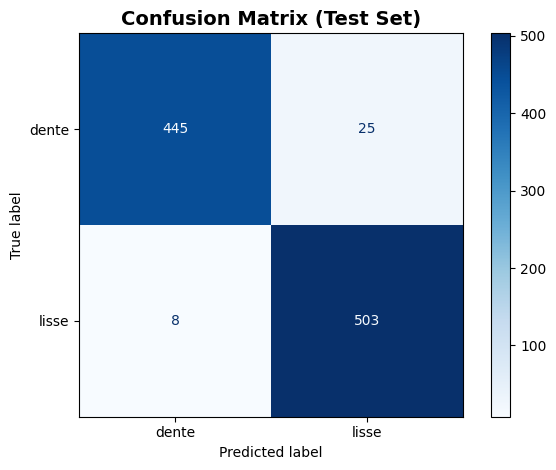

<Figure size 800x600 with 0 Axes>

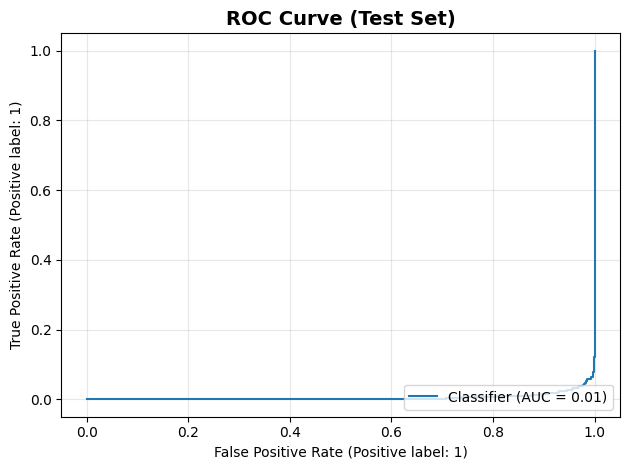

<Figure size 800x600 with 0 Axes>

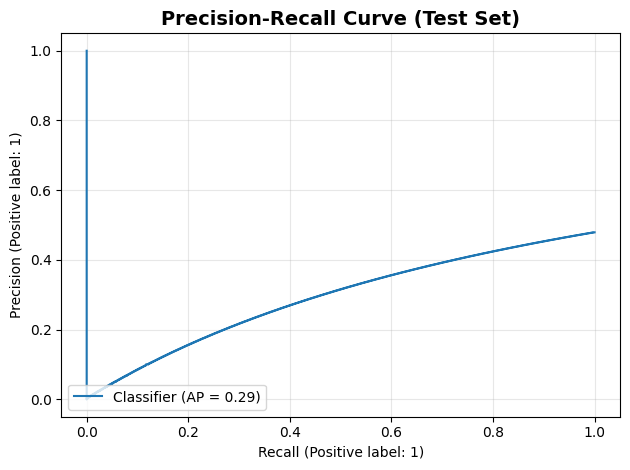


✅ All done! Model saved as 'best_model.pth'
📈 Final Test Accuracy: 96.64%


In [9]:
print("\n📊 Generating visualizations...")

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(values_format='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions((y_true==pos_idx).astype(int), y_proba)
plt.title("ROC Curve (Test Set)", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
PrecisionRecallDisplay.from_predictions((y_true==pos_idx).astype(int), y_proba)
plt.title("Precision-Recall Curve (Test Set)", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ All done! Model saved as 'best_model.pth'")
print(f"📈 Final Test Accuracy: {acc*100:.2f}%")